In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pybamm
from time import time
import pickle
from datetime import datetime, timedelta
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from scipy import interpolate
import os

import mscc_ecm_aging_test_DOD100 as worker
import multiprocessing as mp

print(pybamm.__version__)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15

24.9.0


In [2]:
n_var = 5

In [3]:
X_grid = np.load(f'X_grid_var{n_var}.npy')
len(X_grid)

14400

In [4]:
X_grid

array([[0.2 , 0.2 , 0.2 , 3.7 , 3.95],
       [0.2 , 0.2 , 0.2 , 3.7 , 4.  ],
       [0.2 , 0.2 , 0.2 , 3.7 , 4.05],
       ...,
       [2.  , 2.  , 1.  , 3.85, 4.  ],
       [2.  , 2.  , 1.  , 3.85, 4.05],
       [2.  , 2.  , 1.  , 3.85, 4.1 ]])

In [5]:
X_grid[0]

array([0.2 , 0.2 , 0.2 , 3.7 , 3.95])

In [6]:
X_test = X_grid[0]
print(X_test)
p = mp.Pool(processes = 1)
ecm_data_y_temp = p.starmap(worker.aging_test_results,[X_test])
ecm_data_y_temp

[0.2  0.2  0.2  3.7  3.95]


[[4.999784305869806, 0.8650864868928823]]

In [7]:
n_div = 20
n_sample_div = int(len(X_grid)/n_div)
print(n_sample_div)

720


In [8]:
ecm_data_y = []
for i in range(n_div):
    print(i)
    num_core = 10
    p = mp.Pool(processes = num_core)
    st_time = time()
    ecm_data_y_temp = p.starmap(worker.aging_test_results,X_grid[n_sample_div*i:n_sample_div*(i+1)]) 
    ecm_data_y.append(ecm_data_y_temp)
    np.save(f'ecm_data_y_var{n_var}_n_div{i}.npy',ecm_data_y)
    ed_time = time()
    print('Time',np.round((ed_time-st_time),2)/60, 'minutes')
    p.close()
    p.join()

0
Time 3.8738333333333332 minutes
1
Time 3.6353333333333335 minutes
2
Time 3.582333333333333 minutes
3
Time 3.5993333333333335 minutes
4
Time 3.653833333333333 minutes
5
Time 3.5846666666666667 minutes
6
Time 3.8511666666666664 minutes
7
Time 3.716833333333333 minutes
8
Time 3.6743333333333337 minutes
9
Time 3.7671666666666668 minutes
10
Time 3.5281666666666665 minutes
11
Time 3.4716666666666667 minutes
12
Time 3.5148333333333333 minutes
13
Time 3.4765 minutes
14
Time 3.6388333333333334 minutes
15
Time 3.7271666666666667 minutes
16
Time 3.708666666666667 minutes
17
Time 3.6738333333333335 minutes
18
Time 3.5433333333333334 minutes
19
Time 3.5233333333333334 minutes


In [9]:
ecm_data_y = np.load('ecm_data_y_var5_n_div19.npy').reshape(-1,2)

In [10]:
ecm_data_y

array([[4.99978431, 0.86508649],
       [4.99978436, 0.86508665],
       [4.99978443, 0.86508783],
       ...,
       [0.66799437, 0.72775597],
       [0.64014206, 0.72045853],
       [0.61476164, 0.71379608]])

In [11]:
ecm_data_y = np.array(ecm_data_y)

In [12]:
np.save(f'ecm_data_X_var{n_var}.npy',X_grid)
np.save(f'ecm_data_y_var{n_var}.npy',ecm_data_y)
np.load(f'ecm_data_y_var{n_var}.npy')

array([[4.99978431, 0.86508649],
       [4.99978436, 0.86508665],
       [4.99978443, 0.86508783],
       ...,
       [0.66799437, 0.72775597],
       [0.64014206, 0.72045853],
       [0.61476164, 0.71379608]])

In [13]:
ecm_data = np.concatenate([X_grid,ecm_data_y.flatten().reshape(-1,2)],axis=1)
np.save(f'ecm_data_var{n_var}.npy',ecm_data)

In [14]:
np.load(f'ecm_data_var{n_var}.npy')

array([[0.2       , 0.2       , 0.2       , ..., 3.95      , 4.99978431,
        0.86508649],
       [0.2       , 0.2       , 0.2       , ..., 4.        , 4.99978436,
        0.86508665],
       [0.2       , 0.2       , 0.2       , ..., 4.05      , 4.99978443,
        0.86508783],
       ...,
       [2.        , 2.        , 1.        , ..., 4.        , 0.66799437,
        0.72775597],
       [2.        , 2.        , 1.        , ..., 4.05      , 0.64014206,
        0.72045853],
       [2.        , 2.        , 1.        , ..., 4.1       , 0.61476164,
        0.71379608]])

### Data 분석

In [15]:
import numpy as np
import matplotlib.pyplot as plt


ecm_data_load = np.load(f'ecm_data_var{n_var}.npy')
X_grid = ecm_data_load[:,:5]
ecm_data_y = ecm_data_load[:,-2:]

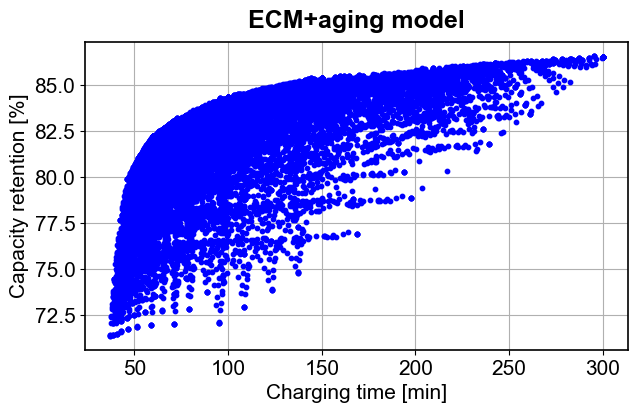

In [16]:
plt.figure(1,figsize=(7,4))
plt.rcParams['font.size'] = 15
plt.grid(zorder=0)
ax = plt.subplot(1,1,1)

plt.scatter(ecm_data_y[:,0]*60,ecm_data_y[:,1]*100,zorder=5,s=10,c='b',label='ECM+aging model')
plt.xlabel('Charging time [min]')
plt.ylabel('Capacity retention [%]')
plt.title('ECM+aging model',pad=10,fontweight='bold')

for spine in ax.spines.values():
     spine.set_linewidth(1.2)
# plt.ylim(0.57, 0.83)
# plt.xlim(0,2)
# plt.legend()

In [17]:
ecm_data = np.load('ecm_data_var5.npy')
ecm_data_X = ecm_data[:,0:5]
ecm_data_y = ecm_data[:,5:]

In [18]:
print(ecm_data_X)
print(ecm_data_y)

[[0.2  0.2  0.2  3.7  3.95]
 [0.2  0.2  0.2  3.7  4.  ]
 [0.2  0.2  0.2  3.7  4.05]
 ...
 [2.   2.   1.   3.85 4.  ]
 [2.   2.   1.   3.85 4.05]
 [2.   2.   1.   3.85 4.1 ]]
[[4.99978431 0.86508649]
 [4.99978436 0.86508665]
 [4.99978443 0.86508783]
 ...
 [0.66799437 0.72775597]
 [0.64014206 0.72045853]
 [0.61476164 0.71379608]]


In [19]:
import joblib
from sklearn.neighbors import KNeighborsRegressor

# KNN 모델 정의 (기본적으로 Euclidean 거리 사용)
knn = KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='auto')

# 모델 학습
knn.fit(X_grid, ecm_data_y)

# 모델 저장
joblib.dump(knn, 'ecm_interp_knn.pkl')

# 저장된 모델 불러오기
ecm_interp_knn = joblib.load('ecm_interp_knn.pkl')

# 불러온 모델로 예측
new_input = np.array([0.3,0.3,0.3,3.9,4.2]).reshape(-1,5)
y_pred = ecm_interp_knn.predict(new_input)
print(y_pred)

[[3.91524067 0.86057951]]


In [20]:
X_io = [[0.2,  0.4,  0.3,  3.7,  4.05],
 [0.8,  0.6,  1. ,  3.7 , 4.1 ],
 [1.,   1.2 , 1.  , 3.8 , 3.95],
 [1.4 , 1.4  ,1.  , 3.7 , 4.05]]

ecm_interp_knn.predict(X_io)

array([[3.64567067, 0.86012611],
       [1.49729116, 0.84020466],
       [0.97002286, 0.82002044],
       [0.78542323, 0.80037281]])

In [21]:

def find_pareto_front(data):
    pareto_front_idx = []
    pareto_front = []
    for i, p1 in enumerate(data):
        is_dominated = False
        for j, p2 in enumerate(data):
            if i != j:
                # p2가 p1을 지배하는지 확인
                if p2[0] <= p1[0] and p2[1] >= p1[1]:
                    is_dominated = True
                    break
        if not is_dominated:
            pareto_front_idx.append(i)
            pareto_front.append(p1)
    
    pareto_front = np.array(pareto_front)
    
    # 첫 번째 컬럼(0번째 인덱스)에 대해 오름차순 정렬
    sorted_indices = np.argsort(pareto_front[:, 0])
    pareto_front = pareto_front[sorted_indices]
    
    return np.array(pareto_front_idx)[sorted_indices], pareto_front


In [23]:
pareto_front_idx, pareto_front = find_pareto_front(ecm_data_y)
pareto_X = X_grid[pareto_front_idx]
pareto_df = pd.DataFrame(pareto_X,columns=['X1','X2','X3','X4','X5'])
pareto_df['tc'] = pareto_front[:,0]
pareto_df['Cr'] = pareto_front[:,1]

In [24]:
pareto_df

,X1,X2,X3,X4,X5,tc,Cr
0,2.0,2.0,1.0,3.70,4.10,0.614762,0.713979
1,1.8,2.0,1.0,3.70,4.10,0.623501,0.720934
2,2.0,1.8,1.0,3.85,4.10,0.626192,0.723796
3,1.8,2.0,1.0,3.75,4.10,0.628262,0.724629
4,2.0,1.8,1.0,3.80,4.10,0.632284,0.728172
...,...,...,...,...,...,...,...
254,0.2,0.2,0.3,3.85,4.00,4.638414,0.864244
255,0.2,0.2,0.3,3.75,4.05,4.717883,0.864429
256,0.2,0.2,0.3,3.75,4.10,4.791819,0.864602
257,0.2,0.2,0.9,3.75,4.10,4.873825,0.864892
